<a href="https://colab.research.google.com/github/ameliavasiliu/DS3021_Final_Project/blob/main/Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Overview and brief Data Summary and Expectations

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [36]:
df = pd.read_csv("data/Airplane_Crashes_and_Fatalities_Since_1908 2.csv")

In [37]:
# getting an idea of what information out data contains
df.head()

,Date,Time,Location,Operator,Flight #,Route,Type,Registration,cn/In,Aboard,Fatalities,Ground,Summary
0,09/17/1908,17:18,"Fort Myer, Virginia",Military - U.S. Army,NaN,Demonstration,Wright Flyer III,NaN,1,2.0,1.0,0.0,"During a demonstration flight, a U.S. Army fly..."
1,07/12/1912,06:30,"AtlantiCity, New Jersey",Military - U.S. Navy,NaN,Test flight,Dirigible,NaN,NaN,5.0,5.0,0.0,First U.S. dirigible Akron exploded just offsh...
2,08/06/1913,NaN,"Victoria, British Columbia, Canada",Private,-,NaN,Curtiss seaplane,NaN,NaN,1.0,1.0,0.0,The first fatal airplane accident in Canada oc...
3,09/09/1913,18:30,Over the North Sea,Military - German Navy,NaN,NaN,Zeppelin L-1 (airship),NaN,NaN,20.0,14.0,0.0,The airship flew into a thunderstorm and encou...
4,10/17/1913,10:30,"Near Johannisthal, Germany",Military - German Navy,NaN,NaN,Zeppelin L-2 (airship),NaN,NaN,30.0,30.0,0.0,Hydrogen gas which was being vented was sucked...


We aim to explore the Operator variable to see if certain types of operators are associated with more plane crashes. We will also examine if a particular type of plane results in more fatalities in a crash than others, and also identify the leading causes of crashes. Essentially, we want to explore whether certain flying conditions—such as the location, plane type, number of people aboard, etc.—are more dangerous for flying.

Additionally, a time series graph will be useful to examine if plane crash fatalities have increased or decreased over time. It could also be valuable to create a heatmap to identify any “hotspot” locations for crashes around the world.

Some challenges will arise with handling NaN values, especially in the flight number and registration variables. This means we will focus more on variables with more complete data. Identifying the cause of the crash will be tricky, as the Summary column contains free-text descriptions. We anticipate using code to extract certain patterns from the strings in the Summary field to get a sense of the leading causes of crashes. This will likely be the most challenging part, especially to ensure we don’t overlook any critical information when filtering.

In [38]:
# removing columns that we don't need to use since most values are Nan and we aren't interested in exploring them
df = df.drop(columns=['Flight #', 'Route', 'Registration', 'cn/In'])

# Basic EDA

In [39]:
pd.crosstab(df['Operator'], df['Fatalities'].sum())
# there seem to be a lot of operators, will have to clean and combine certain operators that are similar

col_0,105479.0
Operator,
A B Aerotransport,2
AB Aerotransport,3
ACES Colombia,3
ADC Airlines,2
ADES Colombia,2
...,...
Zantop Air Transport,4
Zantop Airways,1
Zantop International Airlines,1


In [40]:
pd.crosstab(df['Type'], df['Fatalities'].sum())
# again lots of rows need to clean, also doesn't appear to have a correlation?

col_0,105479.0
Type,
AAC-1 Toucan,1
AEGK,1
AT L98 Carvair,1
ATR 42-300,1
ATR-42-300,1
...,...
de Havilland Dove 1,2
de Havilland Dragon 1,1
de Havilland RU-6A Beaver /Bell UH-1H,1


In [41]:
# want to observe if plane crashes have increased over the years
df['Year'] = pd.to_datetime(df['Date']).dt.year
pd.crosstab(df['Year'], df['Fatalities'].sum())

col_0,105479.0
Year,
1908,1
1912,1
1913,3
1915,2
1916,5
...,...
2005,51
2006,49
2007,54


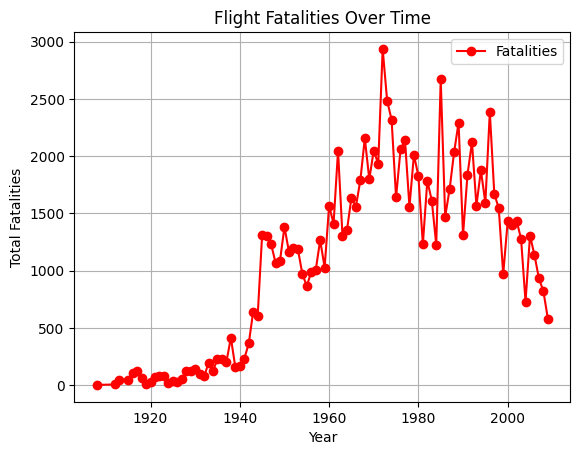

In [42]:
df['Date'] = pd.to_datetime(df['Date'], errors='coerce') # date-time format
df['Year'] = df['Date'].dt.year # extracting the year
fatalities_by_year = df.groupby('Year')['Fatalities'].sum() # group by year

plt.plot(fatalities_by_year, marker='o', linestyle='-', color='red', label='Fatalities') # simple graph to show trend
plt.title('Flight Fatalities Over Time')
plt.xlabel('Year')
plt.ylabel('Total Fatalities')
plt.grid(True)
plt.legend()
plt.show()

Overall, we can conclude that a lot of our variables need heavy cleaning and grouping - specifically, the location, operator, plane type, and summary variables. By cleaning and grouping these variables we will be able to draw more significant conclusions and be able to cross tabulate variables more effectively to draw out potential patterns.

In [43]:
df['Summary'] = df['Summary'].fillna('').str.lower().str.replace(r'[^a-z\s]', '', regex=True).str.strip()


cause_keywords = {
   'weather': ['storm', 'lightning', 'turbulence', 'wind', 'hurricane', 'rain', 'fog', 'snow', 'ice', 'icing', 'microburst', 'poor visibility'],
   'engine failure': ['engine', 'power loss', 'flameout', 'engine failure', 'lost power', 'engine stopped'],
   'pilot error': ['pilot error', 'misjudged', 'failed to', 'overcorrected', 'wrong altitude', 'navigation error', 'loss of control', 'stall', 'did not follow', 'goaround', 'approach mismanagement'],
   'mechanical failure': ['mechanical', 'malfunction', 'broke', 'structural failure', 'detached', 'gear collapsed', 'wing failure'],
   'collision': ['midair', 'collision', 'collided with', 'hit another aircraft', 'crashed into'],
   'fire/explosion': ['fire', 'explosion', 'exploded', 'burned', 'caught fire'],
   'military action': ['missile', 'shot down', 'attack', 'bomb', 'friendly fire'],
   'bird strike': ['bird', 'bird strike', 'ingested bird'],
   'fuel issue': ['fuel', 'ran out of fuel', 'fuel starvation', 'fuel exhaustion'],
   'controlled flight into terrain (CFIT)': ['flew into a mountain', 'crashed onto a mountain', 'hit terrain', 'struck a mountain'],
   'hijacking/terrorism': ['hijack', 'grenade', 'terrorist', 'bomb', 'explosive'],
   'unknown': ['unknown', 'undetermined', 'no cause reported', 'unclear', ''],
}


In [44]:
def assign_cause(summary):
   for cause, keywords in cause_keywords.items():
       for kw in keywords:
           if kw in summary:
               return cause
   return 'other'  # fallback if no keyword is found


df['Cause'] = df['Summary'].apply(assign_cause)


df['Cause'].value_counts()

Cause
weather                                  1534
unknown                                  1476
collision                                 734
engine failure                            586
pilot error                               364
fire/explosion                            199
mechanical failure                        127
military action                           109
controlled flight into terrain (CFIT)      76
fuel issue                                 40
hijacking/terrorism                        22
bird strike                                 1
Name: count, dtype: int64

In [45]:
df['Proportion_Killed'] = df['Fatalities']/df['Aboard'] #creating proportion killed column

df_recent = df[df['Date'].dt.year>=1990]
df_recent.head()

,Date,Time,Location,Operator,Type,Aboard,Fatalities,Ground,Summary,Year,Cause,Proportion_Killed
2514,1991-02-22,NaN,"Cazombo, Angola",Fuerza Area Angolaise,Antonov AN-26,47.0,47.0,0.0,shot down by surfacetoair missile launced by u...,1991,military action,1.000000
3908,1990-02-05,08:37,"Near Ibague, Colombia",Helicopteros Nacionales de Colombia,Grumman G-159 Gulfstream I,15.0,15.0,0.0,struck mt el saluda at ft near image after an...,1990,pilot error,1.000000
3912,1990-01-02,13:40,"Java Sea, Indonesia",Pelita Air Service,CASA 212 Aviocar 200,16.0,9.0,0.0,ditched into the java sea after experiencing m...,1990,engine failure,0.562500
3913,1990-01-13,12:56,"Near Pervouralsk, Russia",Aeroflot,Tupolev TU-134A,71.0,27.0,0.0,a fire in the rear cargo hold and fire warning...,1990,weather,0.380282
3914,1990-01-15,08:30,"Pico Blanco, Costa Rica",SANSA,CASA 212 Aviocar 200,23.0,23.0,0.0,crashed about feet up on ft pico blanco moun...,1990,weather,1.000000


# Analysis

Our current guiding question
- What factors (operator, type, and crash summary) are associated with more deadly plane crashes (larger proportion of deaths)?

Instructions ask for a prediction question so maybe we can change the wording to something like:
- Given factors like operator, aircraft type, and crash summary, can we predict the proportion of fataliies in commercial plane crashes after 1990?

In [46]:
# 
# cleaning and one hot encoding our features
# 

#top 5 operators
top_operators = df_recent['Operator'].value_counts().nlargest(5).index
df_recent.loc[:, 'Operator_Grouped'] = df_recent['Operator'].apply(lambda x: x if x in top_operators else 'Other')

#top 5 plane types
top_types = df_recent['Type'].value_counts().nlargest(5).index
df_recent.loc[:, 'Type_Grouped'] = df_recent['Type'].apply(lambda x: x if x in top_types else 'Other')

#filter for our model
model_df = df_recent[['Proportion_Killed', 'Operator_Grouped', 'Type_Grouped', 'Cause']].dropna()

#one hot encoding
X = pd.get_dummies(model_df[['Operator_Grouped', 'Type_Grouped', 'Cause']], drop_first=True)
y = model_df['Proportion_Killed']

/tmp/ipykernel_24287/1957202371.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_recent.loc[:, 'Operator_Grouped'] = df_recent['Operator'].apply(lambda x: x if x in top_operators else 'Other')
/tmp/ipykernel_24287/1957202371.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_recent.loc[:, 'Type_Grouped'] = df_recent['Type'].apply(lambda x: x if x in top_types else 'Other')


In [47]:
#
# building the regression model
# 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#build and fit model
model = LinearRegression()
model.fit(X_train, y_train)

#predict on test set
y_pred = model.predict(X_test)

#evaluate
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse:.4f}')
print(f'R^2 Score: {r2:.4f}')

Mean Squared Error: 0.0943
R^2 Score: 0.0140


The very low R-squared means that the model explains ony about 1.4% of the variance in crash fatality proportions. While there are some trends in the data, it seems that crash fatality outcomes are highly variable and can be influenced by many unpredictable factors not captured in our dataset and model.

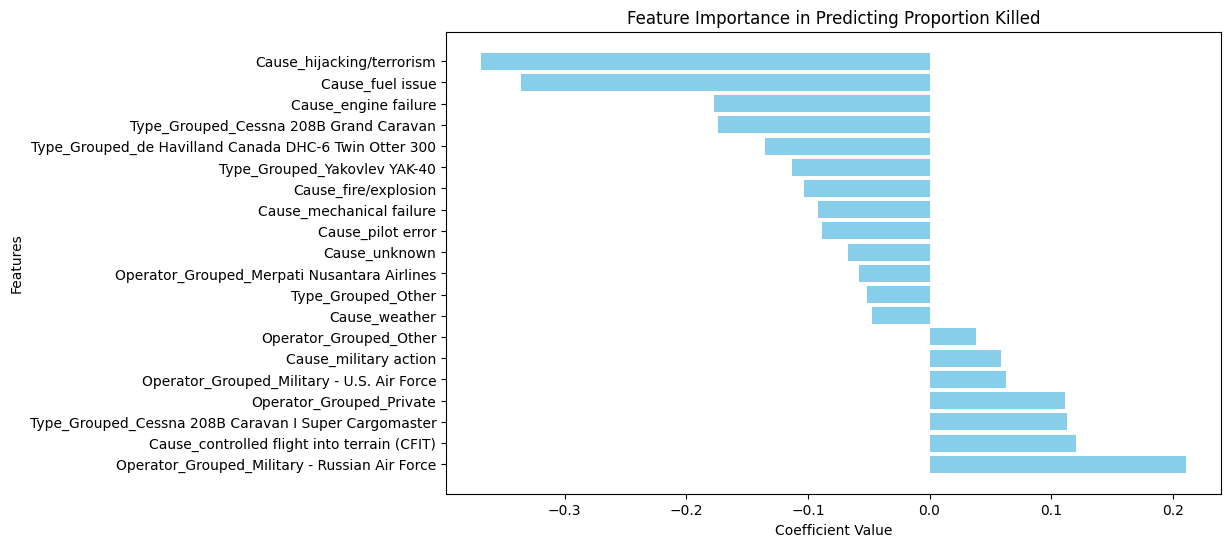

In [48]:
#
# plotting feature importance - first graph for assignment
#

features = X.columns
coeffs = model.coef_

#dataframe for plotting
coef_df = pd.DataFrame({'Feature': features, 'Coefficient': coeffs}).sort_values(by='Coefficient', ascending=False)

#plot (includes cause, operator, and type)
plt.figure(figsize=(10, 6))
plt.barh(coef_df['Feature'], coef_df['Coefficient'], color='skyblue')
plt.xlabel('Coefficient Value')
plt.title('Feature Importance in Predicting Proportion Killed')
plt.ylabel('Features')
plt.show()

This graph shows the operators, types, and causes that have the biggest positive/negative impacts on fatality proportion. Negative coefficients are associated with a higher proportion of deaths, while positive coefficients are associated with a lower proportion.

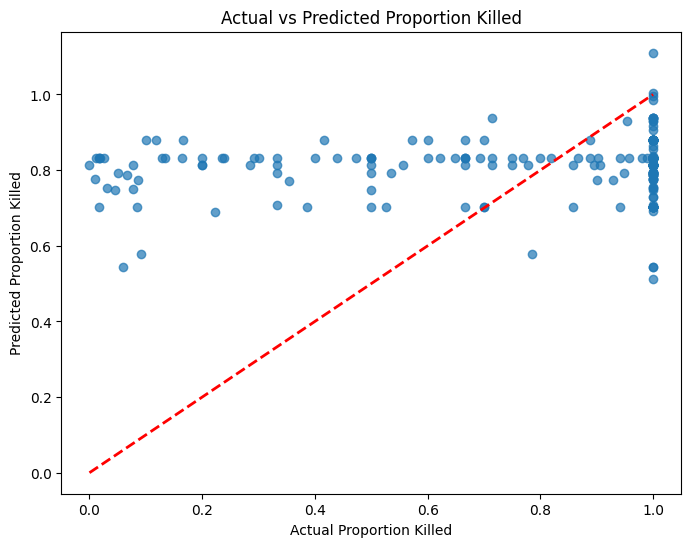

In [49]:
#
# actual vs predicted plot - second graph for assignment
# 

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
plt.title('Actual vs Predicted Proportion Killed')
plt.xlabel('Actual Proportion Killed')
plt.ylabel('Predicted Proportion Killed')
plt.show()

This scatterplot shows how well the model's predictions line up with the actual outcomes. This suggests that the model tends to overestimate fatality rates and has difficulty capturing variation in actual outcomes. In other words, airplane crashes are largely unpredictable and factors in this dataset/model are insufficient to fully capture the complexity of survival outcomes.